In [90]:
from IPython.display import HTML

HTML('''<script>
code_show=true;
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [213]:
import string

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from textblob import TextBlob
from nltk.corpus import stopwords
from datetime import datetime

pd.options.mode.chained_assignment = None  # turn off SettingWithCopyWarning

In [ ]:
%load_ext rpy2.ipython

In [202]:
data = pd.read_csv('data/news_headlines/news_headline_data.csv')

### Basic Sentiment Analysis by Outlet

#### Data Prep

In [191]:
def prep_data(data):
    """
    Lowercase, remove punctuation, and remove numbers.
        """
    data.loc[:, 'article_title'] = data.loc[:, 'article_title'].str.lower()
    data.loc[:, 'article_title'] = data.loc[:, 'article_title'].str.replace(r'[^\w\s]+', '')
    data.loc[:, 'article_title'] = data.loc[:, 'article_title'].str.replace('\d+', '')
    return final_data

In [200]:
def filter_dates(data):
    """
    Remove data from before covid.
    """
    data = data.loc[data['date'] != 'continuously updated', ]
    data.loc[:, 'date'] = [datetime.strptime(date, '%Y-%m-%d') for date in data.loc[:, 'date']]
    start_date = datetime.strptime('2021-01-01', '%Y-%m-%d')
    data = data.loc[data['date'] >= start_date, ]
    return data

In [181]:
def remove_stopwords(data):
    """
    Removes stopwords.
    """
    stop = stopwords.words('english')
    data.loc[:, 'article_title'] = data.loc[:, 'article_title'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    return data

In [182]:
def simple_sentiment(data):
    """
    Creates a simple sentiment score for each news title using TextBlob.
    """
    data.loc[:, 'sentiment_score'] = [TextBlob(title).sentiment.polarity for title in data.loc[:, 'article_title']]
    return data

In [204]:
cleaned_data = clean_data(data)

In [214]:
filtered_data = filter_dates(cleaned_data)

In [209]:
prepped_data = remove_stopwords(filtered_data)

In [210]:
sentiment_data = simple_sentiment(prepped_data)

#### Plot

In [215]:
outlet_sentiment = sentiment_data.groupby('publisher', as_index=False)['sentiment_score'].mean()

In [216]:
# loosely based on https://www.allsides.com/media-bias/media-bias-ratings#ratings
# range from 0 (super liberal) to 4 (super conservative)
conservatism_score = pd.DataFrame({
    'publisher': ['ap', 'breitbart', 'dailykos', 'fox', 'politico', 'washington_times'],
    'conservatism': [1, 4, 0, 3, 1, 2]
})

outlet_sentiment = outlet_sentiment.merge(conservatism_score)
outlet_sentiment = outlet_sentiment.sort_values('conservatism')

Text(0.5, 1.0, 'Mean Article Titles Sentiment by News Outlet')

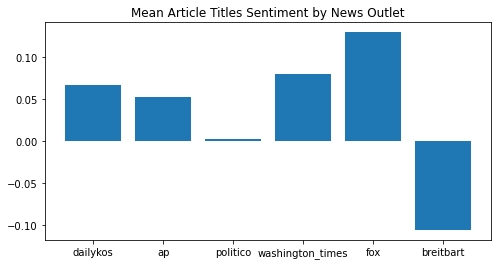

In [221]:
plt.figure(figsize=(8, 4))
plt.bar(x='publisher', height='sentiment_score', data=outlet_sentiment)
plt.title('Mean Article Titles Sentiment by News Outlet')

In [218]:
time_sentiment = sentiment_data.groupby('date', as_index=False)['sentiment_score'].mean()

Text(0.5, 1.0, 'Mean Sentiment Over Time')

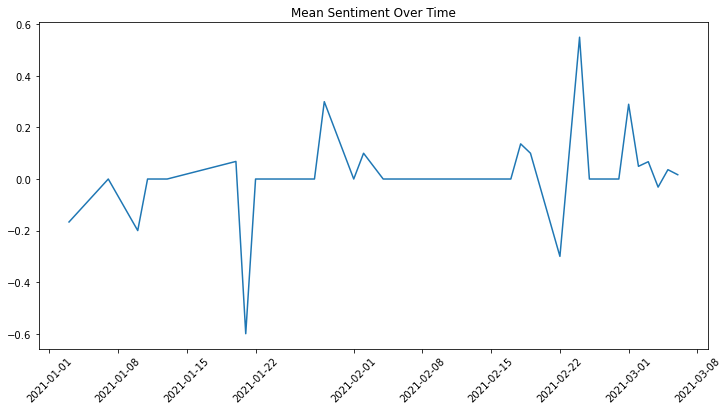

In [222]:
# sentiment over time
# not really enough data to do this by outlet yet
# would be more robust with more data in general
plt.figure(figsize=(12, 6))
plt.plot('date', 'sentiment_score', data=time_sentiment)
plt.xticks(rotation=45)
plt.title('Mean Sentiment Over Time')

### Keyness (relative frequency)

In [237]:
keyness_data = sentiment_data.groupby('publisher')['article_title'].apply(' '.join).reset_index()

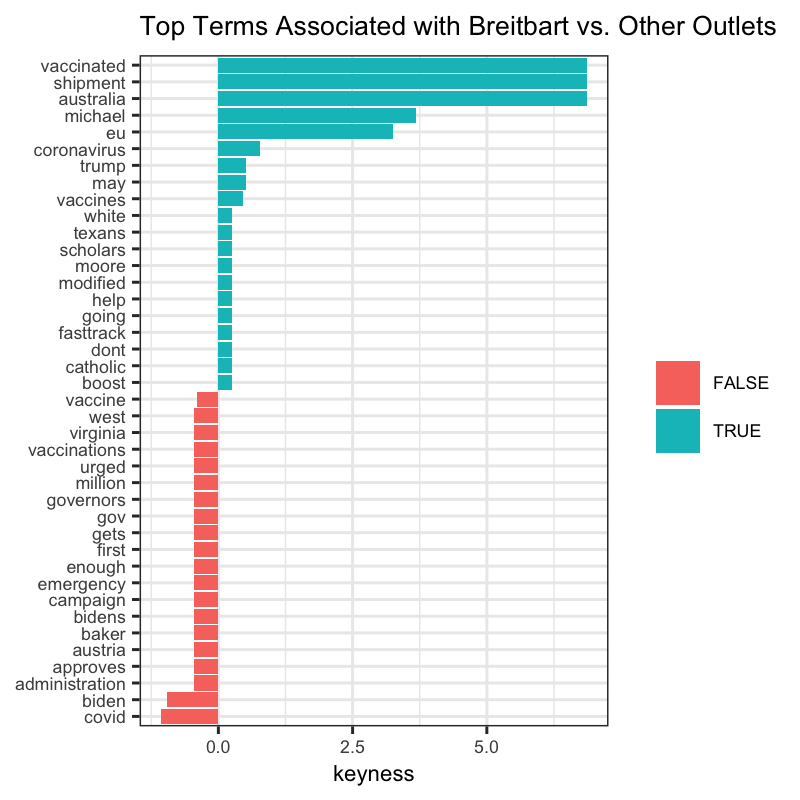

In [249]:
%%R -i keyness_data -w 4 -h 4 --units in -r 200

library(quanteda)
library(ggplot2)

keyness_corpus <- corpus(keyness_data$article_title)
docnames(keyness_corpus) <- keyness_data$publisher
docvars(keyness_corpus, "publisher") <- keyness_data$publisher
keyness_dfm <- dfm(keyness_corpus)

keyness_model <- textstat_keyness(keyness_dfm, target = "breitbart")
keyness_data <- textplot_keyness(keyness_model)$data

ggplot(keyness_data, 
       aes(x = reorder(feature, keyness),
           y = keyness)) +
  geom_bar(stat = "identity", 
           aes(fill = right)) +
  coord_flip() +
  theme_bw() +
  theme(axis.title.y = element_blank(),
        text = element_text(size = 8)) +
  labs(x = "Chi-Squared",
       title = "Top Terms Associated with Breitbart vs. Other Outlets",
       fill = "")
  